# **SET-UP AND DEPENDENCIES**

In [ ]:
# Load the Demand file.
# Please note that due to human subject research rules, the MIMIC-III cannot be publicly provided. I invite you to review the enclosed code and slides to familiarize yourself with the project.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Chief Complaint          19312 non-null  object
 1   All Dx                   19134 non-null  object
 2   Present Illness History  19622 non-null  object
 3   tokens                   20000 non-null  object
 4   tokens_expanded          20000 non-null  object
 5   tokens_lemmatized        20000 non-null  object
 6   tokens_final             20000 non-null  object
dtypes: object(7)
memory usage: 1.1+ MB


# **TEXT PREPARATION**

In [4]:
# Extract 2,000 records (will help with computational speed).
# As LDA is an unsupervised learning model, traditional split into train/test is not mandatory.
lda_2k = lda_df.iloc[:5000].reset_index(drop=True)

In [5]:
# Remove blank Present Illness History records.
lda_2k = lda_2k[lda_2k['Present Illness History'].notna()]
# lda_2k.info()

In [6]:
print(type(lda_2k["tokens_final"].iloc[0])) # from pre-processing, tokens_final is a string while gensim requires lists of tokens.

<class 'str'>


Latent Dirichlet Allocation is one of the most popular methods for performing topic modeling. Each document consists of various words and each topic can be associated with some words. The aim behind the LDA to find topics that the document belongs to, on the basis of words contains in it. It assumes that documents with similar topics will use a similar group of words. This enables the documents to map the probability distribution over latent topics and topics are probability distribution.
Generative Process: LDA uses a generative process to create documents. This involves:
1. Choosing a distribution of topics for each document.
2. For each word in the document, selecting a topic based on the topic distribution.
3. Generating the word from the selected topic's word distribution.

Generative modeling is a class of machine learning where the goal is to learn the underlying distribution of data so the model can generate new, similar data.



In [7]:
# Convert each row from string to list
lda_2k["tokens_final"] = lda_2k["tokens_final"].apply(ast.literal_eval)

In [8]:
print(type(lda_2k["tokens_final"].iloc[0]))

<class 'list'>


# **INITIAL MODEL**

In [9]:
# Create a dictionary of unique terms (takes a list of lists).
dictionary = corpora.Dictionary(lda_2k["tokens_final"])
# This dictionary lets us convert each document into a list of (word_id, frequency) pairs.
# Each unique word across all documents gets an integer ID and the number of documents in which it appears.
# The dictionary is built from the entire corpus and holds word-to-ID mappings for all documents.

# Filter out very rare or very frequent words.
dictionary.filter_extremes(no_below=20, no_above=0.8)
# Remove tokens that appear in fewer than 20 documents (1% of the corpus).
# Remove tokens that appear in more than 80% of documents. Clinical notes have a large proportion of common words.
# Reduces vocabulary size, improves LDA topic clarity, speeds up model training, removes "junk" words or overly broad terms


# Convert tokenized documents to bag-of-words format
corpus = [dictionary.doc2bow(text) for text in lda_2k["tokens_final"]]
# doc2bow stands for “document to bag-of-words”.
# Converts the list of words into a list of (word_id, count) tuples, where: word_id is the ID assigned by the dictionary (i.e., all of the docs)
# and count is how many times that word appears in the document (one given document).
# The resulting list of bag-of-words for all documents becomes the corpus — a list of doc2bow() results, one per document.

Run the model with a range of hyperparameters.
NOTE: With stronger computational resources, the best practice is to run a broader range of hyperparameters' values on a larger data set.  

Hyperparameters for tuning:
1. **num_topics**
This is the number of topics the model will try to learn, pre-set based on the knowledge of the corpus. It defines the length of each document's topic distribution vector, θ (theta), whose sparsity is controlled by hyperparameter alpha α.

2. **alpha**
This is a Dirichlet distribution prior over the θ vectors (document-topic distributions). It controls how many topics each document is likely to contain, from low (each document dominated by 1 -2 topics) to high (each document represent multiple topics). Common range [0.01, 1.0].

3. **eta**
β (word mix per topic) is drawn from Dirichlet eta (η). Every word has some (possibly low) probability to be associated with every topic; eta controls sparsity or density of the word-topic matrix. Common range [0.001, 1.0].

4. **iterations**
The iterations hyperparameter in LDA refers to how many times the model updates topic assignments within each pass over the corpus. It controls how deeply each document is processed during training. Each word token in a document has a topic assignment (z), and the model refines those topic assignments during each pass (epoch). Gibbs Sampling (used by gensim) is a type of Markov Chain Monte Carlo method. It works by repeatedly sampling topic assignments (z) for each word token, one at a time, based on conditional probabilities. Over many iterations, these samples converge toward the true posterior distribution.

5. **passes**
passes is akin to NN epochs (how many times the model goes over all samples/entire corpus).

6. **minimum_probability**
Controls how many topics are returned per document by setting a threshold for filtering topic probabilities. Topics with probabilities below this threshold are not returned in the output.

In [10]:
# Set model hyperparameters (all priors assumed symmetric)
# Note: hyperparamter ranges, number of topics/iterations/passes are reduced and simplified for computational efficiency.

num_topics_list = [20, 30]             # Exectation driven by the multiple admitting departments, diagnosis, etc. Need balance between generalization and granularity.
alpha_list = [0.5, 0.7]                # Smooth document-topic mix. Expect a given note to be generated by a variety of topics.
eta_list = [0.5, 0.7]                  # Smooth topic-word mix. Expect a significant number of shared words.
minimum_probability = 0.05             # Filter low-probability topics per note.
passes = 5                             # Ensures convergence and topic stabilization (lower value for computational resources)
iterations = 25                        # Ensures convergence and topic stabilization (lower value for computational resources)
chunksize = 50                         # 1% of the corpus 5000; notes are voluminous and have overlapping topics therefore a batch of 50 is expected to converge on topic assignment

results = [] # empty list to store results after each iteration.

for num_topics, alpha, eta in product(num_topics_list, alpha_list, eta_list):
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        alpha=alpha,
        eta=eta,
        passes=passes,
        minimum_probability=minimum_probability,
        chunksize=chunksize,
        iterations=iterations,
        random_state=42,
        per_word_topics=False # argument when set to True returns 3 outputs: list of topics and list of word tokens per topic (standard + phi-values which are prob of topics at word level)
    )
# model performance will be monitored with the coherence score which measures how semantically consistent the top words in a topic are. Desired trend: higher.
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=lda_2k["tokens_final"],
        dictionary=dictionary,
        coherence='c_v'  # a coherence method that measures semantic similarity using sliding windows and indirect word co-occurrence.
    )

    coherence_score = coherence_model.get_coherence()

    results.append({
        'num_topics': num_topics,
        'alpha': alpha,
        'eta': eta,
        'coherence': coherence_score
    })

    print(f"Topics: {num_topics}, Alpha: {alpha}, Eta: {eta}, Coherence: {coherence_score:.4f}")


Topics: 20, Alpha: 0.5, Eta: 0.5, Coherence: 0.5591
Topics: 20, Alpha: 0.5, Eta: 0.7, Coherence: 0.5654
Topics: 20, Alpha: 0.7, Eta: 0.5, Coherence: 0.5271
Topics: 20, Alpha: 0.7, Eta: 0.7, Coherence: 0.5233
Topics: 30, Alpha: 0.5, Eta: 0.5, Coherence: 0.5326
Topics: 30, Alpha: 0.5, Eta: 0.7, Coherence: 0.5324
Topics: 30, Alpha: 0.7, Eta: 0.5, Coherence: 0.5353
Topics: 30, Alpha: 0.7, Eta: 0.7, Coherence: 0.5272


In [11]:
best_result = max(results, key=lambda x: x['coherence'])
print("Best:", best_result)

Best: {'num_topics': 20, 'alpha': 0.5, 'eta': 0.7, 'coherence': 0.5654263319341183}


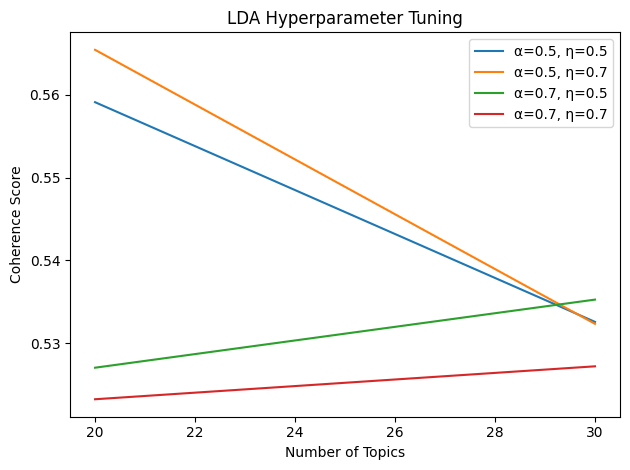

In [12]:
# Display performance results

results_df = pd.DataFrame(results)

# Plot coherence by number of topics
for a in alpha_list:
    for e in eta_list:
        subset = results_df[(results_df['alpha'] == a) & (results_df['eta'] == e)]
        plt.plot(subset['num_topics'], subset['coherence'], label=f'α={a}, η={e}')

plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('LDA Hyperparameter Tuning')
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
# Print top 10 topics with top 25 words each
top_topics = lda_model.show_topics(num_topics=10, num_words=25, formatted=False)

for i, topic in top_topics:
    print(f"\nTopic {i}:")
    print(", ".join([f"{word} ({weight:.4f})" for word, weight in topic]))


Topic 20:
today (0.2634), see (0.1923), earlier (0.0496), come (0.0183), told (0.0055), since (0.0044), state (0.0040), sent (0.0035), appointment (0.0033), slightly (0.0033), yesterday (0.0031), clinic (0.0028), currently (0.0027), weekly (0.0027), previously (0.0021), nausea/vomiting (0.0021), denies (0.0020), emergency department (0.0020), least (0.0019), go (0.0017), 10 (0.0017), h (0.0017), present (0.0016), central (0.0015), full (0.0014)

Topic 38:
due (0.0669), dose (0.0473), start (0.0357), acute (0.0334), admission (0.0331), high (0.0319), renal (0.0310), elevate (0.0297), prednisone (0.0281), transplant (0.0199), prior (0.0174), increase (0.0153), follow (0.0146), kidney (0.0145), outpatient (0.0139), steroid (0.0138), taper (0.0125), syndrome (0.0123), set (0.0119), thought (0.0118), failure (0.0109), also (0.0108), use (0.0106), previously (0.0090), stop (0.0089)

Topic 3:
chest (0.0703), pain (0.0552), dyspnea (0.0269), denies (0.0262), review (0.0228), system (0.0214), 

# **OPTIMIZING THE MODEL**

After the initial model run, some improvements can be made. Original pre-processing preserved all numbers. Given the objective of the model, numeric expressions can be removed for model comparison.  

In [9]:
# Create a function using re.
def remove_numeric_tokens(token_list):
    cleaned = [
        token for token in token_list
        if not re.search(r'\d|%', token)  # removes all numbers and associated slashes and percentage signs.
    ]
    return cleaned

# Save the results in a new column.
lda_2k["tokens_updated"] = lda_2k["tokens_final"].apply(remove_numeric_tokens)

In [10]:
# Validate that compound clinical expressions are intact.
print(lda_2k["tokens_final"].iloc[0])
print(lda_2k["tokens_updated"].iloc[0])

['hepatitis c virus', 'cirrhosis', 'c/b', 'ascites', 'hiv', 'antiretroviral therapy', 'h/o', 'intravenous drug use', 'chronic obstructive pulmonary disease', 'bioplar', 'post-traumatic stress disorder', 'present', 'outside hospital', 'emergency department', 'worsen', 'abd', 'distension', 'past', 'week', 'pt', 'report', 'self-discontinue', 'lasix', 'spirnolactone', 'week', 'ago', 'feel', 'like', 'anything', 'want', 'put', 'chemical', 'follow', 'na-restrict', 'diet', 'past', 'week', 'note', 'worsen', 'abd', 'distension', 'discomfort', 'denies', 'edema', 'shortness of breath', 'orthopnea', 'denies', 'fever , chill , nausea , and vomit', 'discharge or discontinue', 'dysuria', 'food', 'poison', 'week', 'ago', 'eat', 'stale', 'cake', 'n/v', '20', 'min', 'food', 'ingestion', 'resolve', 'day', 'denies', 'recent', 'illness', 'sick', 'contact', 'note', 'notice', 'gum', 'bleeding', 'brushing', 'teeth', 'recent', 'week', 'denies', 'easy', 'bruising', 'melena', 'bright red blood per rectum', 'hemet

Re-run the model on the updated tokens and revised hyperparameters.

In [11]:
dictionary = corpora.Dictionary(lda_2k["tokens_updated"])
dictionary.filter_extremes(no_below=20, no_above=0.8)
corpus = [dictionary.doc2bow(text) for text in lda_2k["tokens_updated"]]

In [12]:
# Re-set the hyperparameters (higher eta and lower number of topics appear to improve performance)

num_topics_list = [20, 25]
alpha_list = [0.5, 0.7]
eta_list = [0.7, 0.8]
minimum_probability = 0.05
passes = 5
iterations = 25
chunksize = 50

results = [] # empty list to store results after each iteration.

for num_topics, alpha, eta in product(num_topics_list, alpha_list, eta_list):
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        alpha=alpha,
        eta=eta,
        passes=passes,
        minimum_probability=minimum_probability,
        chunksize=chunksize,
        iterations=iterations,
        random_state=42,
        per_word_topics=False
    )
# model performance will be monitored with the coherence score which measures how semantically consistent the top words in a topic are. Desired trend: higher.
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=lda_2k["tokens_updated"],
        dictionary=dictionary,
        coherence='c_v'
    )

    coherence_score = coherence_model.get_coherence()

    results.append({
        'num_topics': num_topics,
        'alpha': alpha,
        'eta': eta,
        'coherence': coherence_score
    })

    print(f"Topics: {num_topics}, Alpha: {alpha}, Eta: {eta}, Coherence: {coherence_score:.4f}")


Topics: 20, Alpha: 0.5, Eta: 0.7, Coherence: 0.5134
Topics: 20, Alpha: 0.5, Eta: 0.8, Coherence: 0.5310
Topics: 20, Alpha: 0.7, Eta: 0.7, Coherence: 0.5034
Topics: 20, Alpha: 0.7, Eta: 0.8, Coherence: 0.5073
Topics: 25, Alpha: 0.5, Eta: 0.7, Coherence: 0.5172
Topics: 25, Alpha: 0.5, Eta: 0.8, Coherence: 0.5174
Topics: 25, Alpha: 0.7, Eta: 0.7, Coherence: 0.5165
Topics: 25, Alpha: 0.7, Eta: 0.8, Coherence: 0.5154


In [13]:
best_result = max(results, key=lambda x: x['coherence'])
print("Best:", best_result)

Best: {'num_topics': 20, 'alpha': 0.5, 'eta': 0.8, 'coherence': 0.5310314517203467}


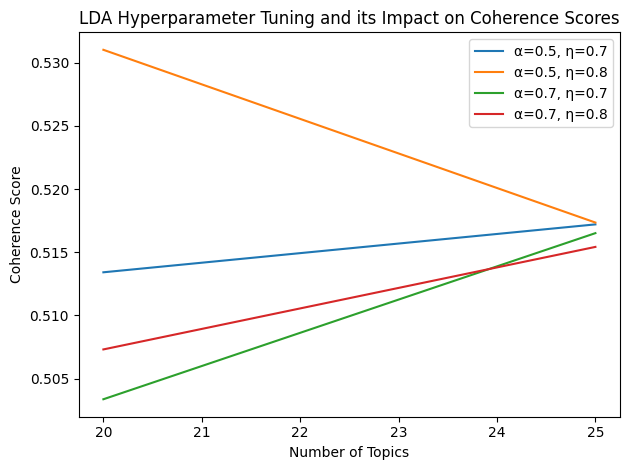

In [15]:
# Display performance results

results_df = pd.DataFrame(results)

# Plot coherence by number of topics
for a in alpha_list:
    for e in eta_list:
        subset = results_df[(results_df['alpha'] == a) & (results_df['eta'] == e)]
        plt.plot(subset['num_topics'], subset['coherence'], label=f'α={a}, η={e}')

plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('LDA Hyperparameter Tuning and its Impact on Coherence Scores')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# Print top 10 topics with top 25 words each
top_topics = lda_model.show_topics(num_topics=10, num_words=25, formatted=False)

for i, topic in top_topics:
    print(f"\nTopic {i}:")
    print(", ".join([f"{word} ({weight:.4f})" for word, weight in topic]))


Topic 14:
last (0.0382), day (0.0373), report (0.0360), week (0.0349), past (0.0283), ago (0.0255), also (0.0236), feel (0.0193), symptom (0.0191), state (0.0177), start (0.0177), pain (0.0171), month (0.0154), present (0.0145), several (0.0142), emergency department (0.0130), one (0.0126), well (0.0124), since (0.0123), patient (0.0112), take (0.0111), time (0.0110), year (0.0104), two (0.0102), worsen (0.0097)

Topic 3:
patient (0.0428), emergency department (0.0364), notable (0.0347), lab (0.0329), room air (0.0288), initial (0.0243), vitals (0.0238), give (0.0185), floor (0.0180), white blood cell (0.0177), arrival (0.0172), acute (0.0144), cr (0.0141), transfer (0.0141), exam (0.0135), report (0.0133), urinalysis (0.0132), sodium (0.0130), lactate (0.0121), normal saline (0.0111), prior (0.0098), mild (0.0091), vital sign (0.0089), chest x-ray (0.0089), k (0.0088)

Topic 10:
low (0.0539), edema (0.0312), extremity (0.0293), bilateral (0.0289), renal (0.0187), leg (0.0177), swell 